# Bitcoin Price Prediction

In this notebook, we predict the price of the bitcoin in the future, given the historical trends of the prices of bitcoin from the past 7-8 years.

The data for this project is taken from - https://www.coindesk.com/price/bitcoin/

## Check GPU

In [3]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-3dfa3515-e463-201c-dd84-a19df713273f)


## Get Data

In [4]:
# Import data with pandas
import pandas as pd
# Let's check our bitcoin data and parse the dates since it's a time series problem
df = pd.read_csv("BTC_USD_2014-11-04_2021-12-05-CoinDesk.csv", 
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas column 1 is datetime

# Check the dataframe
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-04,BTC,324.467934,323.826186,333.539527,323.106623
2014-11-05,BTC,328.644408,324.424164,330.671610,320.902900
2014-11-06,BTC,337.921358,328.653046,342.384170,328.597125
2014-11-07,BTC,348.992860,337.921358,352.585895,336.236830
2014-11-08,BTC,341.459753,348.992860,351.651854,340.196145


In [5]:
# Check the number of samples we have
len(df)

2589

We've collected data samples of Bitcoin for the past 7 years but there are only 2581 samples.

Deep Learning model like a big chunk of data to work efficiently but in time series problems we will often see there are a small number of examples for the dataset

In [6]:
# We only want the closing price of the bitcoin data
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753
...,...
2021-12-01,56973.182042
2021-12-02,57237.271634
2021-12-03,56524.829562


Plot the bitcoin prices data

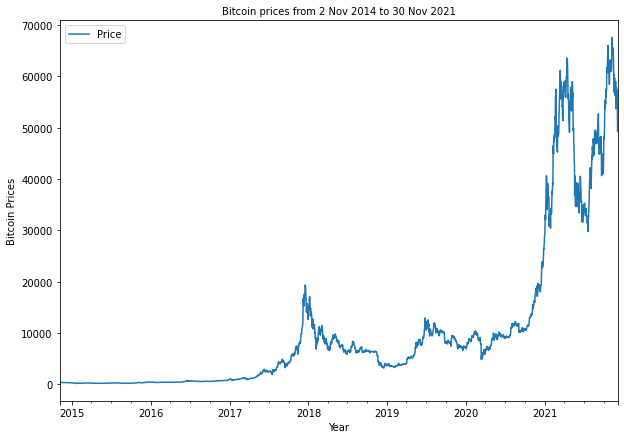

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("Bitcoin Prices")
plt.xlabel("Year")
plt.title("Bitcoin prices from 2 Nov 2014 to 30 Nov 2021", fontsize=10);

## Make Windowed Datasets

In [8]:
# Setup global variables for window size and horizon
HORIZON = 1 # predict 1 day
WINDOW_SIZE = 7 # use data of last 7 days to predict horizon

In [9]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset

  Example : if horizon=1 then
  Input = [1, 2, 3, 4, 5, 6, 7, 8] -> Output = ([1, 2, 3, 4, 5, 6, 7], [8])
  """
  return x[:,:-horizon],x[:,-horizon:]

In [10]:
import numpy as np
# Create function to view Numpy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array to a 2D array of sequential labelled windows with window_size and horizon size labels
  """
  # 1. Create a window of specific window_size (add the horizon at the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window Indexes : \n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  
  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  
  return windows,labels

In [11]:
# Create a list of bitcoin prices from the datasets
prices = bitcoin_prices.Price.to_numpy()
prices[:10]

array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
       344.745289, 357.239982, 371.116917, 366.664633, 428.882925])

In [12]:
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(2582, 2582)

In [13]:
# Check shapes
full_windows.shape, full_labels.shape

((2582, 7), (2582, 1))

In [14]:
# Make train and test splits
def make_test_splits(windows,labels,test_split=0.2):
  """
  Make train and test sets for windows and labels.
  """
  split_size = int(len(windows) * (1-test_split)) # Default 80% training data/ 20% testing data 
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [15]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_test_splits(full_windows,full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2065, 517, 2065, 517)

In [16]:
train_windows[:10], train_labels[:10]

(array([[324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
         344.745289, 357.239982],
        [328.644408, 337.921358, 348.99286 , 341.459753, 344.745289,
         357.239982, 371.116917],
        [337.921358, 348.99286 , 341.459753, 344.745289, 357.239982,
         371.116917, 366.664633],
        [348.99286 , 341.459753, 344.745289, 357.239982, 371.116917,
         366.664633, 428.882925],
        [341.459753, 344.745289, 357.239982, 371.116917, 366.664633,
         428.882925, 418.944218],
        [344.745289, 357.239982, 371.116917, 366.664633, 428.882925,
         418.944218, 399.688315],
        [357.239982, 371.116917, 366.664633, 428.882925, 418.944218,
         399.688315, 374.983975],
        [371.116917, 366.664633, 428.882925, 418.944218, 399.688315,
         374.983975, 388.040069],
        [366.664633, 428.882925, 418.944218, 399.688315, 374.983975,
         388.040069, 387.062731],
        [428.882925, 418.944218, 399.688315, 374.983975, 388.040069,
    

In [17]:
test_windows[:10], test_labels[:10]

(array([[9184.180386, 9135.931565, 9235.438742, 9090.015161, 9065.500081,
         9138.5     , 9083.8     ],
        [9135.931565, 9235.438742, 9090.015161, 9065.500081, 9138.5     ,
         9083.8     , 9346.448521],
        [9235.438742, 9090.015161, 9065.500081, 9138.5     , 9083.8     ,
         9346.448521, 9253.988524],
        [9090.015161, 9065.500081, 9138.5     , 9083.8     , 9346.448521,
         9253.988524, 9437.699097],
        [9065.500081, 9138.5     , 9083.8     , 9346.448521, 9253.988524,
         9437.699097, 9237.455308],
        [9138.5     , 9083.8     , 9346.448521, 9253.988524, 9437.699097,
         9237.455308, 9286.942248],
        [9083.8     , 9346.448521, 9253.988524, 9437.699097, 9237.455308,
         9286.942248, 9235.143666],
        [9346.448521, 9253.988524, 9437.699097, 9237.455308, 9286.942248,
         9235.143666, 9299.538653],
        [9253.988524, 9437.699097, 9237.455308, 9286.942248, 9235.143666,
         9299.538653, 9236.91    ],
        [9

## Make a modelling checkpoint

In [18]:
import tensorflow as tf
checkpoint_path = "model_checkpoints/model_1.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

## Build a basic model for the bitcoin prediction

In [19]:
from tensorflow.keras import layers

# 1. Construct a model
model_1 = tf.keras.Sequential([
  layers.Dense(512, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
],name="model_1")

# 2. Compile our model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[model_checkpoint])

Epoch 1/100
 1/17 [>.............................] - ETA: 26s - loss: 2843.9702 - mae: 2843.9702 - mse: 14316112.0000
Epoch 00001: val_loss improved from inf to 4087.07886, saving model to model_checkpoints/model_1.ckpt
17/17 [==============================] - 2s 13ms/step - loss: 915.9512 - mae: 915.9512 - mse: 2696174.2500 - val_loss: 4087.0789 - val_mae: 4087.0789 - val_mse: 25779442.0000
Epoch 2/100
 1/17 [>.............................] - ETA: 0s - loss: 472.1603 - mae: 472.1603 - mse: 480640.6250
Epoch 00002: val_loss improved from 4087.07886 to 2336.24146, saving model to model_checkpoints/model_1.ckpt
17/17 [==============================] - 0s 5ms/step - loss: 324.7409 - mae: 324.7409 - mse: 347443.7812 - val_loss: 2336.2415 - val_mae: 2336.2415 - val_mse: 9715610.0000
Epoch 3/100
 1/17 [>.............................] - ETA: 0s - loss: 289.2296 - mae: 289.2296 - mse: 320032.5312
Epoch 00003: val_loss improved from 2336.24146 to 1748.91467, saving model to model_checkpoints/mo

In [20]:
# Load the best weights
model_1.load_weights(checkpoint_path)

In [21]:
# Evaluate on full dataset
model_1.evaluate(test_windows,test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 1067.1779 - mae: 1067.1779 - mse: 2598420.5000


[1067.1778564453125, 1067.1778564453125, 2598420.5]

In [22]:
# Make predictions
model_1_preds = model_1.predict(test_windows)

## Make a function to evaluate our model predictions

In [23]:
# MASE Implementation
def mean_absolute_scaled_error(y_true,y_preds):
  """
  Implement MASE provided no seasonality of data is there
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_preds))

  # Find MAE of naive forecast
  mae_naive_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_seasonality

In [24]:
# Create a function to evaluate all evaluation metrics
def calculate_results_time_series(y_true,y_preds):
  """
  Returns a dictionary of MAE, MSE, RMSE, MAPE, MASE metrics for evaluation
  """
  # Make sure the data is in float32 format
  y_true = tf.cast(y_true, tf.float32)
  y_preds = tf.cast(y_preds, tf.float32)
  
  # Calculate different evaluation scores
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_preds)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_preds)
  rmse = tf.math.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_preds)
  mase = mean_absolute_scaled_error(y_true, y_preds)
  
  # Check for different horizons by checking the ndims
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"MAE":mae.numpy(),
          "MSE": mse.numpy(),
          "RMSE": rmse.numpy(),
          "MAPE": mape.numpy(),
          "MASE": mase.numpy()}

In [25]:
# Evaluate our predictions
model_1_results = calculate_results_time_series(tf.squeeze(test_labels), tf.squeeze(model_1_preds))
model_1_results

{'MAE': 1067.1777,
 'MAPE': 2.7910028,
 'MASE': 0.998439,
 'MSE': 2598420.2,
 'RMSE': 1611.9615}

## Create a function to plot our time series data

In [26]:
# Create a function to visualize time series
def plot_time_series(timesteps,values,format=".",start=0,end=None,label=None):
  """
  Plots timesteps vs values (values across timesteps)

  Parameters
  -----------
  timesteps: array of timesteps values
  values: array of values across timesteps
  format: type of graph, eg - . for scatter, - for line, default = .
  start: start of plot - setting a value will index from the particular timestep
  end: end of plot - setting a value will end the plot at particular timestep
  label: a label to show plot about the values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Bitcoin Price")
  if label:
    plt.legend(fontsize=14); # make label bigger
  plt.grid(True);

In [27]:
# Get timesteps of our dataset
timesteps = bitcoin_prices.index.to_numpy()
timesteps

array(['2014-11-04T00:00:00.000000000', '2014-11-05T00:00:00.000000000',
       '2014-11-06T00:00:00.000000000', ...,
       '2021-12-03T00:00:00.000000000', '2021-12-04T00:00:00.000000000',
       '2021-12-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [28]:
# Create train and test splits for our dataset 
split_size = int(0.8 * len(prices))
split_size

# Splitting the datasets by indexing
X_train = timesteps[:split_size]
X_test = timesteps[split_size:]
y_train = prices[:split_size]
y_test = prices[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2071,), (518,), (2071,), (518,))

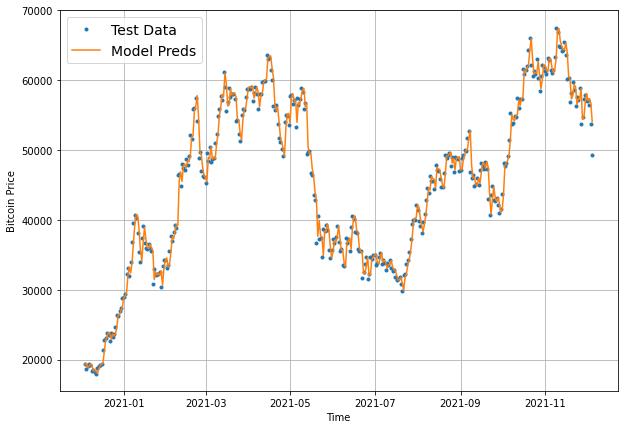

In [29]:
# Let's plot our predictions
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=150,
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds[:,0],
                 start=150,
                 label="Model Preds",
                 format="-");

## Build a model using a Conv1D layer

A conv1D layer takes a shape of : `(batch_size, timesteps, input_dim)`

So we need to shape our data accordingly

In [30]:
# Model Checkpoint
checkpoint_path = "model_checkpoints/model_2.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

In [31]:
# Structure model
model_2 = tf.keras.Sequential([
  layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
  layers.Conv1D(filters=512,
                kernel_size=5,
                padding="causal",
                strides=1,
                activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_conv1D")

# Compile model
model_2.compile(loss=["mae"],
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[model_checkpoint])

Epoch 1/100
16/17 [===========================>..] - ETA: 0s - loss: 1329.8152 - mae: 1329.8152 - mse: 5746400.0000   
Epoch 00001: val_loss improved from inf to 1991.15381, saving model to model_checkpoints/model_2.ckpt
17/17 [==============================] - 7s 22ms/step - loss: 1320.8809 - mae: 1320.8809 - mse: 5701059.5000 - val_loss: 1991.1538 - val_mae: 1991.1538 - val_mse: 8452875.0000
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 318.9673 - mae: 318.9673 - mse: 339368.6250
Epoch 00002: val_loss improved from 1991.15381 to 1842.22681, saving model to model_checkpoints/model_2.ckpt
17/17 [==============================] - 0s 6ms/step - loss: 318.9673 - mae: 318.9673 - mse: 339368.6250 - val_loss: 1842.2268 - val_mae: 1842.2268 - val_mse: 7086989.0000
Epoch 3/100
16/17 [===========================>..] - ETA: 0s - loss: 264.1542 - mae: 264.1542 - mse: 259137.1250
Epoch 00003: val_loss did not improve from 1842.22681
17/17 [==============================] - 0

In [32]:
# Load in best weights
model_2.load_weights(checkpoint_path)

In [33]:
# Evaluate on full test set
model_2.evaluate(test_windows,test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 1067.8071 - mae: 1067.8071 - mse: 2607785.7500


[1067.80712890625, 1067.80712890625, 2607785.75]

In [34]:
# Make predictions
model_2_preds = model_2.predict(test_windows)

In [35]:
# Evaluate our predictions
model_2_results = calculate_results_time_series(tf.squeeze(test_labels), tf.squeeze(tf.squeeze(model_2_preds)))
model_2_results

{'MAE': 1067.8071,
 'MAPE': 2.79868,
 'MASE': 0.99902785,
 'MSE': 2607785.8,
 'RMSE': 1614.864}

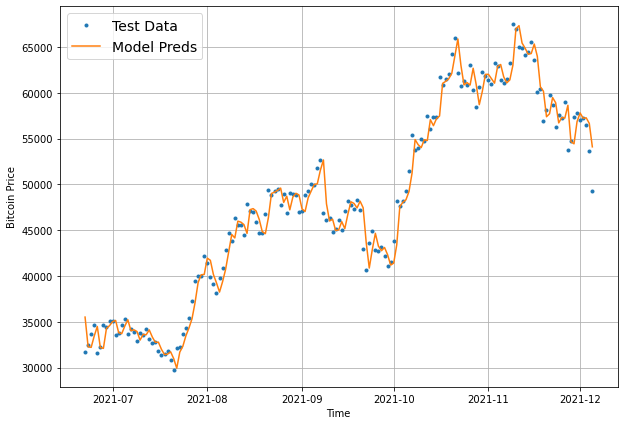

In [36]:
# Plot our predictions
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=350,
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_2_preds[:,:,0],
                 start=350,
                 label="Model Preds",
                 format="-");

## Add block reward column to the bitcoin dataset

To learn about bitcoin block reward check out - https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [37]:
import numpy as np
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 (this block reward isnt in our dataset)
block_reward_2 = 25 # 28 November 2012 (this block reward isn't in our dataset)
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward Dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [38]:
# Create date ranges of where specific block_reward_values should be 
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_2_days

613

In [39]:
# Similarly doing for others
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_3_days

2022

In [40]:
# Add in block_reward column to our dataframe
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None
bitcoin_prices_block.block_reward[:block_reward_2_days] = block_reward_2
bitcoin_prices_block.block_reward[block_reward_2_days:block_reward_3_days] = block_reward_3
bitcoin_prices_block.block_reward[block_reward_3_days:] = block_reward_4
bitcoin_prices_block

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Price,block_reward
Date,,
2014-11-04,324.467934,25
2014-11-05,328.644408,25
2014-11-06,337.921358,25
2014-11-07,348.992860,25
2014-11-08,341.459753,25
...,...,...
2021-12-01,56973.182042,6.25
2021-12-02,57237.271634,6.25
2021-12-03,56524.829562,6.25


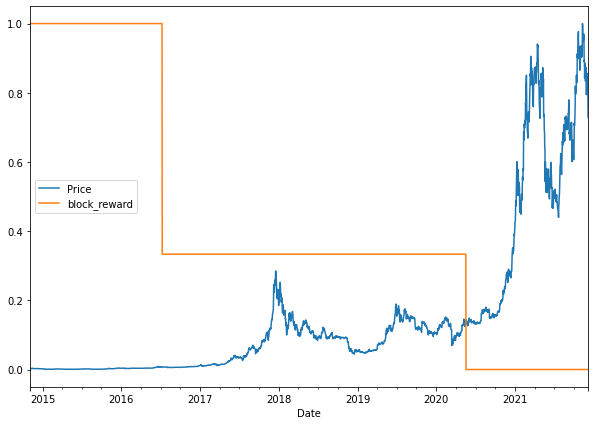

In [41]:
# Plot the dataframe with the same scale
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                       columns=bitcoin_prices_block.columns,
                                                                       index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7));

## Make windowed datasets with pandas

In [42]:
# Setup data parameters
HORIZON = 1
WINDOW_SIZE = 7

In [43]:
# Make a copy of the dataset
bitcoin_prices_windowed = bitcoin_prices_block.copy()

In [44]:
# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_block["Price"].shift(periods=i+1)

# Check the windowed dataframe
bitcoin_prices_windowed.head(15)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-11-04,324.467934,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,328.644408,25,324.467934,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-06,337.921358,25,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN
2014-11-07,348.992860,25,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN
2014-11-08,341.459753,25,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN
2014-11-09,344.745289,25,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN
2014-11-10,357.239982,25,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934,NaN
2014-11-11,371.116917,25,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934
2014-11-12,366.664633,25,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408


In [45]:
# Drop rows with empty values
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-11,25.0,357.239990,344.745300,341.459747,348.992859,337.921356,328.644409,324.467926
2014-11-12,25.0,371.116913,357.239990,344.745300,341.459747,348.992859,337.921356,328.644409
2014-11-13,25.0,366.664642,371.116913,357.239990,344.745300,341.459747,348.992859,337.921356
2014-11-14,25.0,428.882935,366.664642,371.116913,357.239990,344.745300,341.459747,348.992859
2014-11-15,25.0,418.944214,428.882935,366.664642,371.116913,357.239990,344.745300,341.459747


In [46]:
y.head()

Date
2014-11-11    371.116913
2014-11-12    366.664642
2014-11-13    428.882935
2014-11-14    418.944214
2014-11-15    399.688324
Name: Price, dtype: float32

In [47]:
# Make train and test splits
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2065, 2065, 517, 517)

In [48]:
# Create model checkpoint
checkpoint_path = "model_checkpoints/model_3.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

In [49]:
# Create model
model_3 = tf.keras.Sequential([
  layers.Dense(512, activation="relu"),
  layers.Dense(512, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3")

# Compile the model
model_3.compile(loss=["mae"],
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# Fit the model
model_3.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test,y_test),
            callbacks=[model_checkpoint])

Epoch 1/100
 1/17 [>.............................] - ETA: 5s - loss: 4570.0229 - mae: 4570.0229 - mse: 33509316.0000
Epoch 00001: val_loss improved from inf to 3527.49634, saving model to model_checkpoints/model_3.ckpt
17/17 [==============================] - 1s 13ms/step - loss: 994.7090 - mae: 994.7090 - mse: 3659890.0000 - val_loss: 3527.4963 - val_mae: 3527.4963 - val_mse: 19656496.0000
Epoch 2/100
 1/17 [>.............................] - ETA: 0s - loss: 409.5324 - mae: 409.5324 - mse: 370704.5625
Epoch 00002: val_loss improved from 3527.49634 to 1985.13074, saving model to model_checkpoints/model_3.ckpt
17/17 [==============================] - 0s 6ms/step - loss: 386.4093 - mae: 386.4093 - mse: 460190.6250 - val_loss: 1985.1307 - val_mae: 1985.1307 - val_mse: 8206596.5000
Epoch 3/100
 1/17 [>.............................] - ETA: 0s - loss: 277.9969 - mae: 277.9969 - mse: 251362.0156
Epoch 00003: val_loss improved from 1985.13074 to 1712.58472, saving model to model_checkpoints/mod

In [50]:
# Load in best weights
model_3.load_weights(checkpoint_path)

In [51]:
# Evaluate on test set
model_3.evaluate(X_test,y_test)

17/17 [==============================] - 0s 2ms/step - loss: 1070.0448 - mae: 1070.0448 - mse: 2585439.0000


[1070.0447998046875, 1070.0447998046875, 2585439.0]

In [52]:
# Make predictions
model_3_preds = model_3.predict(X_test)

In [53]:
# Evaluate our predictions
model_3_results = calculate_results_time_series(y_test, tf.squeeze(model_3_preds))
model_3_results

{'MAE': 1070.0448,
 'MAPE': 2.8058789,
 'MASE': 1.0011214,
 'MSE': 2585438.8,
 'RMSE': 1607.9299}

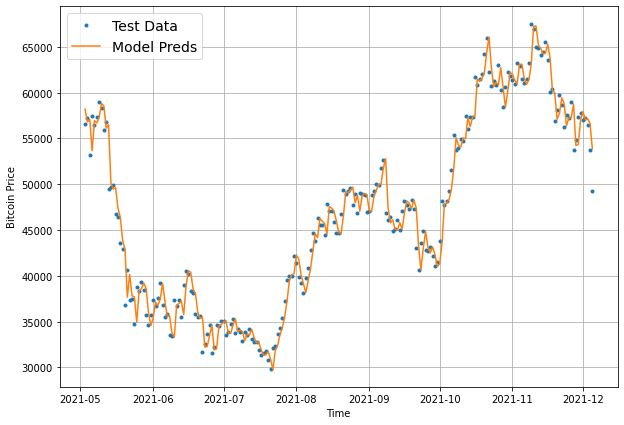

In [54]:
# Plot our predictions
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timesteps[-len(X_test):],
                 values=y_test[:],
                 start=300,
                 label="Test Data")
plot_time_series(timesteps=timesteps[-len(X_test):],
                 values=model_3_preds[:,0],
                 start=300,
                 label="Model Preds",
                 format="-");

### Add the feature of day of week as a column to our dataset

In [55]:
import datetime

In [56]:
# Creating a day of week feature 
X['day_of_week'] = X.index.dayofweek
X.head(10)

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,day_of_week
Date,,,,,,,,,
2014-11-11,25.0,357.239990,344.745300,341.459747,348.992859,337.921356,328.644409,324.467926,1
2014-11-12,25.0,371.116913,357.239990,344.745300,341.459747,348.992859,337.921356,328.644409,2
2014-11-13,25.0,366.664642,371.116913,357.239990,344.745300,341.459747,348.992859,337.921356,3
2014-11-14,25.0,428.882935,366.664642,371.116913,357.239990,344.745300,341.459747,348.992859,4
2014-11-15,25.0,418.944214,428.882935,366.664642,371.116913,357.239990,344.745300,341.459747,5
2014-11-16,25.0,399.688324,418.944214,428.882935,366.664642,371.116913,357.239990,344.745300,6
2014-11-17,25.0,374.983978,399.688324,418.944214,428.882935,366.664642,371.116913,357.239990,0
2014-11-18,25.0,388.040070,374.983978,399.688324,418.944214,428.882935,366.664642,371.116913,1
2014-11-19,25.0,387.062744,388.040070,374.983978,399.688324,418.944214,428.882935,366.664642,2


In [57]:
# Make train and test splits
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2065, 2065, 517, 517)

In [58]:
# Create model checkpoint
checkpoint_path = "model_checkpoints/model_4.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

In [59]:
# Create model
model_4 = tf.keras.Sequential([
  layers.Dense(512, activation="relu"),
  layers.Dense(512, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(HORIZON)
], name="model_4")

# Compile the model
model_4.compile(loss=["mae"],
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# Fit the model
model_4.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test,y_test),
            callbacks=[model_checkpoint])

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 907.3666 - mae: 907.3666 - mse: 3058371.7500   
Epoch 00001: val_loss improved from inf to 3975.34644, saving model to model_checkpoints/model_4.ckpt
17/17 [==============================] - 1s 15ms/step - loss: 907.3666 - mae: 907.3666 - mse: 3058371.7500 - val_loss: 3975.3464 - val_mae: 3975.3464 - val_mse: 24262340.0000
Epoch 2/100
 1/17 [>.............................] - ETA: 0s - loss: 484.6859 - mae: 484.6859 - mse: 463149.9375
Epoch 00002: val_loss improved from 3975.34644 to 1593.84509, saving model to model_checkpoints/model_4.ckpt
17/17 [==============================] - 0s 6ms/step - loss: 288.5541 - mae: 288.5541 - mse: 285878.7500 - val_loss: 1593.8451 - val_mae: 1593.8451 - val_mse: 5268989.0000
Epoch 3/100
 1/17 [>.............................] - ETA: 0s - loss: 191.0257 - mae: 191.0257 - mse: 148598.7812
Epoch 00003: val_loss did not improve from 1593.84509
17/17 [==============================] - 0s 4

In [60]:
# Load in best weights
model_4.load_weights(checkpoint_path)

In [61]:
# Evaluate on test set
model_4.evaluate(X_test,y_test)

17/17 [==============================] - 0s 2ms/step - loss: 1069.1312 - mae: 1069.1312 - mse: 2593272.2500


[1069.1312255859375, 1069.1312255859375, 2593272.25]

In [62]:
# Make predictions
model_4_preds = model_4.predict(X_test)

In [63]:
# Calculate model results
model_4_results = calculate_results_time_series(y_test,tf.squeeze(model_4_preds))
model_4_results

{'MAE': 1069.1312,
 'MAPE': 2.801196,
 'MASE': 1.0002667,
 'MSE': 2593272.5,
 'RMSE': 1610.364}

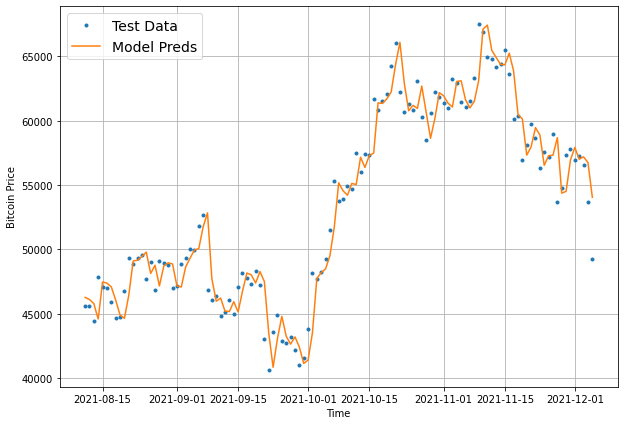

In [64]:
# Plot predictions
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timesteps[-len(X_test):],
                 values=y_test[:],
                 start=400,
                 label="Test Data")
plot_time_series(timesteps=timesteps[-len(X_test):],
                 values=model_4_preds[:,0],
                 start=400,
                 label="Model Preds",
                 format="-");

## N-BEATS Algorithm - Neural Basis Expansion Analysis for Interpretable Time Series Forecasting

We will try to replicate the model architecture from figure 1 of the paper : https://arxiv.org/pdf/1905.10437.pdf

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and model in TensorFlow we can use subclassing.

In [65]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs takes care of all the arguments of the parent class (input_shape, trainable, name, etc) 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers and has relu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # How to go from inputs to outputs
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from the theta layer
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [66]:
# Create dataset 
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-04,324.467934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-06,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN
2014-11-07,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN
2014-11-08,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN
2014-11-09,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN
2014-11-10,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934,NaN
2014-11-11,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934
2014-11-12,366.664633,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408


In [67]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

X

,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,
2014-11-11,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934
2014-11-12,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408
2014-11-13,366.664633,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358
2014-11-14,428.882925,366.664633,371.116917,357.239982,344.745289,341.459753,348.992860
2014-11-15,418.944218,428.882925,366.664633,371.116917,357.239982,344.745289,341.459753
...,...,...,...,...,...,...,...
2021-12-01,57834.357549,57303.185972,54784.900000,53712.210000,58959.315555,57193.709727,57576.849631
2021-12-02,56973.182042,57834.357549,57303.185972,54784.900000,53712.210000,58959.315555,57193.709727
2021-12-03,57237.271634,56973.182042,57834.357549,57303.185972,54784.900000,53712.210000,58959.315555


In [68]:
# Make train and test splits
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2065, 2065, 517, 517)

In [69]:
X_train.shape, y_train.shape

((2065, 7), (2065,))

In [70]:
# Time to make our dataset performant using the tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features and labels by zipping
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch (batch size = 1024 was taken from the paper for nbeats algorithm)
train_dataset = train_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Setting up hyperparameters for our N-Beats algorithm

Many of the hyperparameters can be found on Table 18 in the paper -  https://arxiv.org/pdf/1905.10437.pdf

In [71]:
# Values from N-Beats Paper 
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
WINDOW_SIZE = 7
HORIZON = 1

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = WINDOW_SIZE + HORIZON

In [72]:
# Build the N-BEATS model

# 1. Setup the instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="IntialBlock")

# 2. Create an input layer to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # First stack is the Intial Block so that's why we subtract 1
  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals,backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast,block_forecast], name=f"add_{i}")

# 7. Put together the N-BEATS stack model
model_5 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model")

# 8. Compile the model
model_5.compile(loss=["mae"],
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae","mse"])

# 9. Fit the model
model_5.fit(X_train,y_train,
            epochs=N_EPOCHS,
            validation_data=(X_test,y_test),
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=200,restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=100, verbose=1)])


Epoch 00411: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00511: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [73]:
# Evaluate on test dataset
model_5.evaluate(test_dataset)

1/1 [==============================] - 11s 11s/step - loss: 1060.0703 - mae: 1060.0703 - mse: 2581969.5000


[1060.0703125, 1060.0703125, 2581969.5]

In [74]:
# Make predictions
model_5_preds = model_5.predict(test_dataset)

In [75]:
# Calculate results
model_5_results = calculate_results_time_series(y_test, tf.squeeze(model_5_preds))
model_5_results

{'MAE': 1060.0703,
 'MAPE': 2.7787094,
 'MASE': 0.9917894,
 'MSE': 2581969.5,
 'RMSE': 1606.8508}

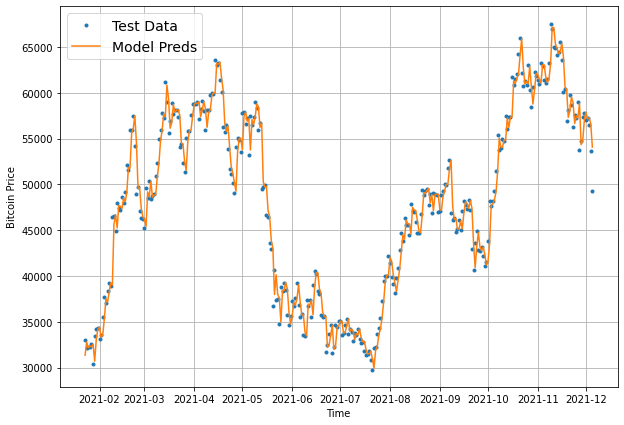

In [76]:
# Plot predictions
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timesteps[-len(X_test):],
                 values=y_test[:],
                 start=200,
                 label="Test Data")
plot_time_series(timesteps=timesteps[-len(X_test):],
                 values=model_5_preds[:,0],
                 start=200,
                 label="Model Preds",
                 format="-");

### Plotting the N-BEATS Model

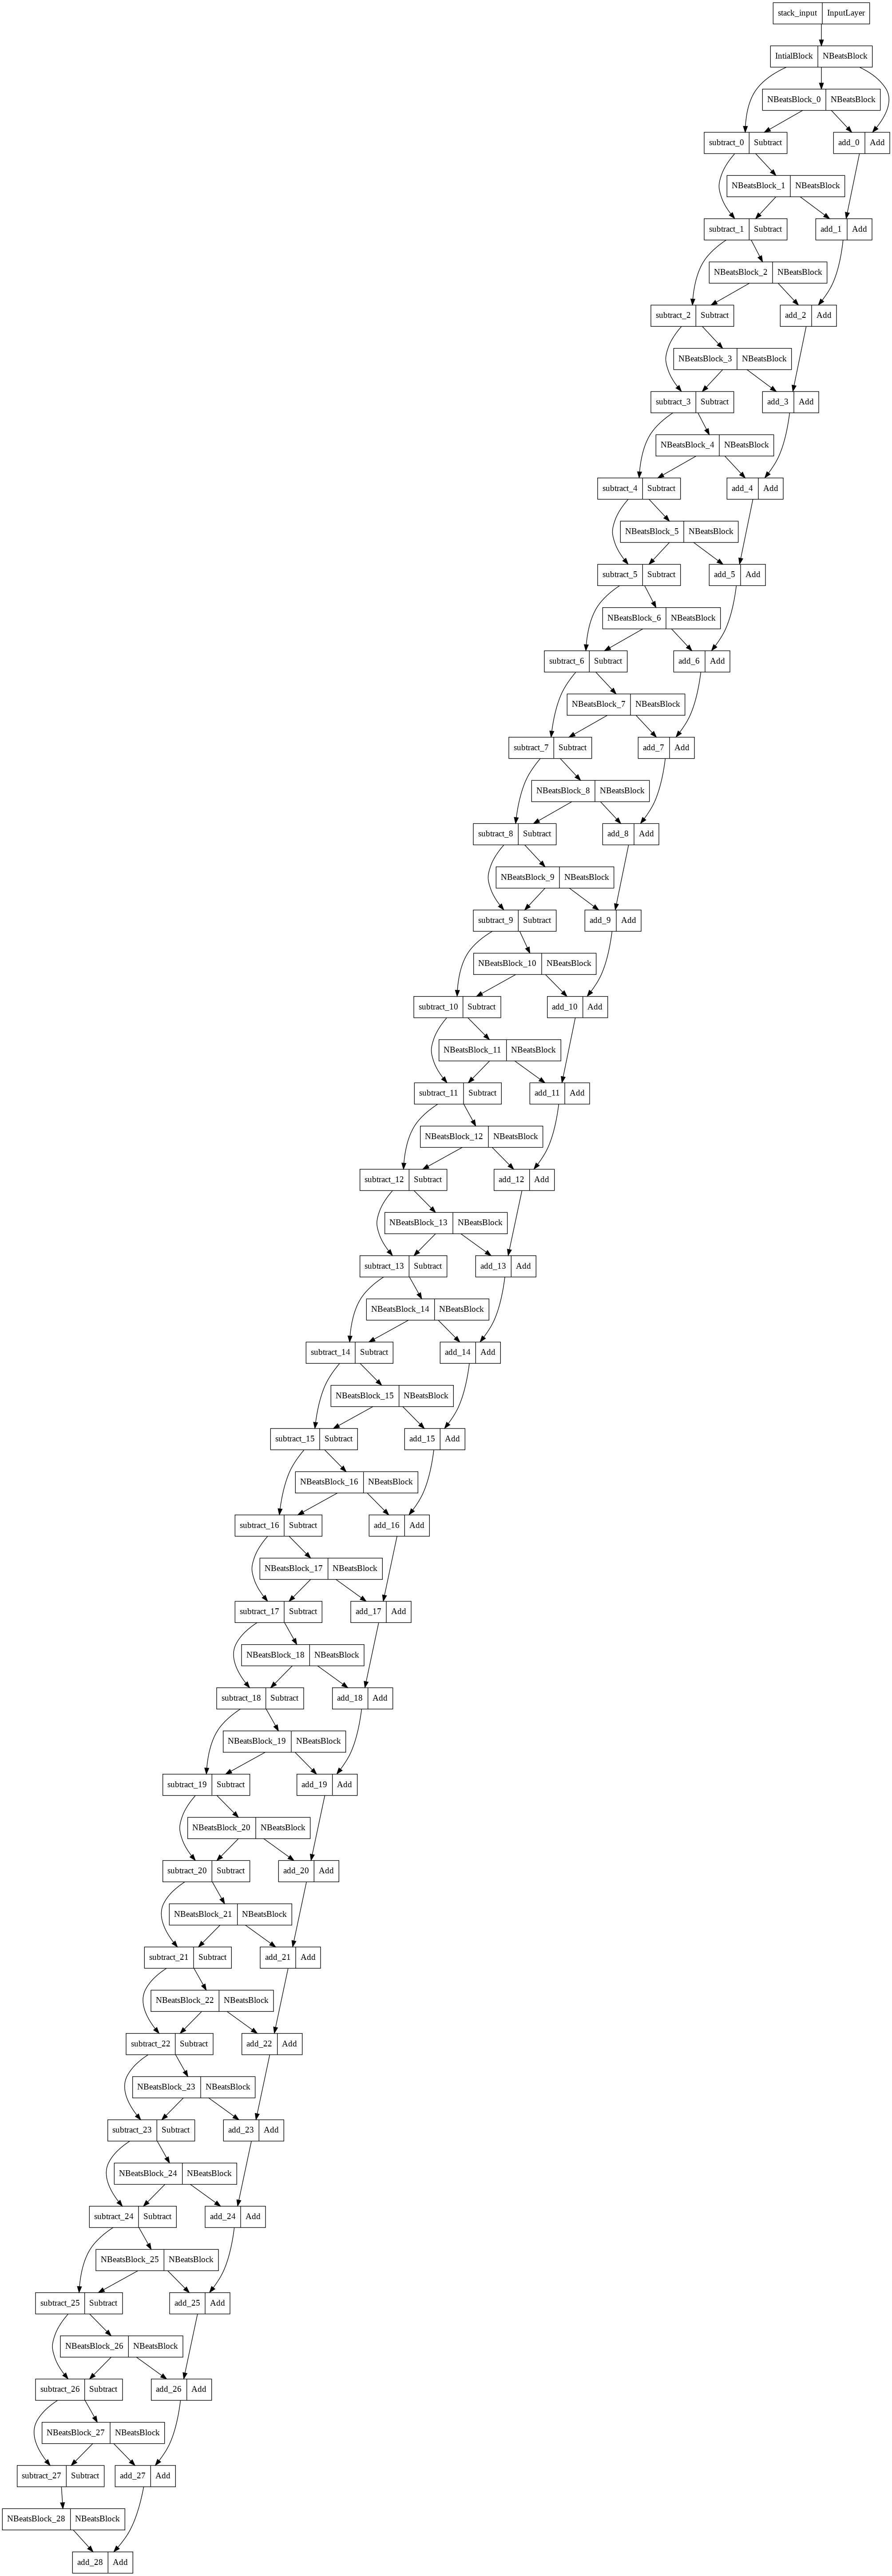

In [77]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

## Train a model on full dataset

Since our N-BEATS model has performed the best we will train the full data on it

In [78]:
# Train model on whole data to make predictions the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price","block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"]

len(X_all), len(y_all)

(2582, 2582)

In [79]:
# Turn our data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Prefetch and batch
dataset_all = dataset_all.batch(1024).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [80]:
# Create model checkpoint
checkpoint_path = "model_checkpoints/model_6.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

In [81]:
# Build the N-BEATS model

# 1. Setup the instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="IntialBlock")

# 2. Create an input layer to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # First stack is the Intial Block so that's why we subtract 1
  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals,backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast,block_forecast], name=f"add_{i}")

# 7. Put together the N-BEATS stack model
model_6 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model")

# 8. Compile the model
model_6.compile(loss=["mae"],
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae","mse"])

# 9. Fit the model
model_6.fit(dataset_all,
            epochs=N_EPOCHS,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss",patience=200,restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",patience=100, verbose=1)])


Epoch 00190: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 01023: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 04193: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [82]:
# Evaluate on train data
model_6.evaluate(dataset_all)

3/3 [==============================] - 1s 16ms/step - loss: 279.8562 - mae: 279.8562 - mse: 472922.4688


[279.8562316894531, 279.8562316894531, 472922.46875]

### Make predictions in the future

In [83]:
# How many timesteps to predict in the future?
INTO_FUTURE = 14

In [84]:
# Create function to make predictions in the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE):
  """
  Make future forecasts into_future steps after value ends.
  
  Returns a list of future forecasts
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make into_future number of predictions, altering the data which gets predicted on each
  for _ in range(into_future):
    # Predict on the last window then append it again and again and again (our model will eventually make forecasts on its own forecast)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on : \n {last_window} -> Prediction : {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [85]:
# Make forecasts in the future
future_forecast = make_future_forecasts(y_all, model_6, INTO_FUTURE)

Predicting on : 
 Date
2021-11-29    57303.185972
2021-11-30    57834.357549
2021-12-01    56973.182042
2021-12-02    57237.271634
2021-12-03    56524.829562
2021-12-04    53694.690000
2021-12-05    49266.120000
Name: Price, dtype: float64 -> Prediction : 56521.34765625

Predicting on : 
 [57834.357549   56973.182042   57237.271634   56524.829562
 53694.69       49266.12       56521.34765625] -> Prediction : 58028.9140625

Predicting on : 
 [56973.182042   57237.271634   56524.829562   53694.69
 49266.12       56521.34765625 58028.9140625 ] -> Prediction : 56887.40625

Predicting on : 
 [57237.271634   56524.829562   53694.69       49266.12
 56521.34765625 58028.9140625  56887.40625   ] -> Prediction : 56794.44140625

Predicting on : 
 [56524.829562   53694.69       49266.12       56521.34765625
 58028.9140625  56887.40625    56794.44140625] -> Prediction : 55977.45703125

Predicting on : 
 [53694.69       49266.12       56521.34765625 58028.9140625
 56887.40625    56794.44140625 55977

In [86]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns an array of datetime values ranging from start_data to start_data + into_future
  """
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [87]:
# Get the last date of the data 
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-12-05 00:00:00')

In [88]:
# Get next 2 weeks of timesteps
next_time_steps = get_future_dates(last_timestep, INTO_FUTURE)
next_time_steps

array(['2021-12-06', '2021-12-07', '2021-12-08', '2021-12-09',
       '2021-12-10', '2021-12-11', '2021-12-12', '2021-12-13',
       '2021-12-14', '2021-12-15', '2021-12-16', '2021-12-17',
       '2021-12-18', '2021-12-19'], dtype='datetime64[D]')

In [89]:
# Add last timestep to next time steps and last forecast to the future forecast so our graph doesn't look disjointed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])

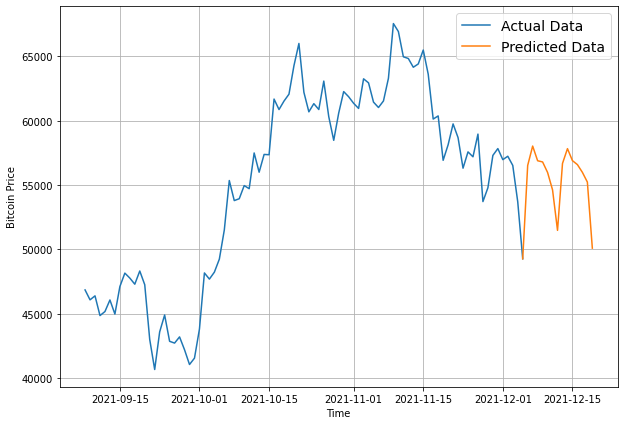

In [90]:
# Plot the graph for future predictions
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, prices, start=2500, format="-", label="Actual Data")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted Data");

In [91]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"model_1": model_1_results,
                              "model_2": model_2_results,
                              "model_3": model_3_results,
                              "model_4": model_4_results,
                              "model_5": model_5_results}).T
model_results

,MAE,MSE,RMSE,MAPE,MASE
model_1,1067.177734,2598420.25,1611.961548,2.791003,0.998439
model_2,1067.807129,2607785.75,1614.864014,2.798680,0.999028
model_3,1070.044800,2585438.75,1607.929932,2.805879,1.001121
model_4,1069.131226,2593272.50,1610.364014,2.801196,1.000267
model_5,1060.070312,2581969.50,1606.850830,2.778709,0.991789


## Creating a function so that our model retrains on the predictions it makes to make further predictions

In [92]:
import numpy as np
# Making future forecastts of Bitcoins (using the whole data)
def pred_model_run(values , X, model , into_future , window_size  , horizon, epochs ):

  '''
  This function train a model for every updated predictions. 

  Arguments:
  ----------
      - values --> labels / truth values. Bitcoin prices 
      - X --> Windowed data of the bitcoin prices (default window size is 7)
      - model --> compiled model with default horizon 1 
      - into_future -->  how many time steps to predict in the future? 
      - window_size --> default is 7 (using the 7 days prices of bitcoin)
      - horizon --> default is 1 (predicting the price of next day)

  Returns: 
  --------
      - model --> a model that has been trained on all the previous predictions + the data
  '''
  future_forecast=[]
  last_window = values[-window_size:]
  X_all = X
  y_all = values
  for _ in range(into_future): 

      # Each time the model is trained for 5 epochs with the updated data
      model.fit(x = X_all , y = y_all , epochs = epochs , verbose = 0)

      future_pred = model.predict(tf.expand_dims(last_window, axis= 0))
      #future_pred = model.predict(last_window)
      print(f'Predicing on: \n {last_window} --> Prediction: {tf.squeeze(future_pred).numpy()}\n')

      future_forecast.append(tf.squeeze(future_pred).numpy())
      #values = np.append(values , tf.squeeze(future_pred).numpy())
      for i in range(0 , len(X_all)):
        x = X_all[i][1:]  # removing the 0th index of the X window ()
        y = y_all[1:] # removing the 0th index  of y 
        X = np.append(x , future_pred) # append the future pred at last to X window
        values = np.append(y , future_pred) # appending the future pred to y 

      # Update the last window 
      last_window = np.append(last_window , future_pred)[-window_size:]


  return model,future_forecast

In [93]:
#. Making the data and labels for window size of 7 and horizon of 1 
full_windows , full_labels = make_windows(prices , window_size= WINDOW_SIZE , horizon= HORIZON)

In [94]:
full_windows.shape , X_all.shape , full_labels.shape , y_all.shape

((2582, 7), (2582, 7), (2582, 1), (2582,))

In [95]:
# Using the above function 
trained_model,future_predictions = pred_model_run(values=tf.squeeze(full_labels) , 
                                                  X=full_windows , 
                                                  model=model_6 , 
                                                  window_size=WINDOW_SIZE , 
                                                  horizon=HORIZON, 
                                                  epochs=10, 
                                                  into_future=14)

Predicing on: 
 [57303.185972 57834.357549 56973.182042 57237.271634 56524.829562
 53694.69     49266.12    ] --> Prediction: 51033.70703125

Predicing on: 
 [57834.357549   56973.182042   57237.271634   56524.829562
 53694.69       49266.12       51033.70703125] --> Prediction: 51380.3203125

Predicing on: 
 [56973.182042   57237.271634   56524.829562   53694.69
 49266.12       51033.70703125 51380.3203125 ] --> Prediction: 50794.05078125

Predicing on: 
 [57237.271634   56524.829562   53694.69       49266.12
 51033.70703125 51380.3203125  50794.05078125] --> Prediction: 50240.984375

Predicing on: 
 [56524.829562   53694.69       49266.12       51033.70703125
 51380.3203125  50794.05078125 50240.984375  ] --> Prediction: 49673.078125

Predicing on: 
 [53694.69       49266.12       51033.70703125 51380.3203125
 50794.05078125 50240.984375   49673.078125  ] --> Prediction: 51167.5703125

Predicing on: 
 [49266.12       51033.70703125 51380.3203125  50794.05078125
 50240.984375   49673.

In [115]:
# Add last timestep to last forecast to the future forecast so our graph doesn't look disjointed
future_predictions = np.insert(future_predictions, 0, prices[-1])

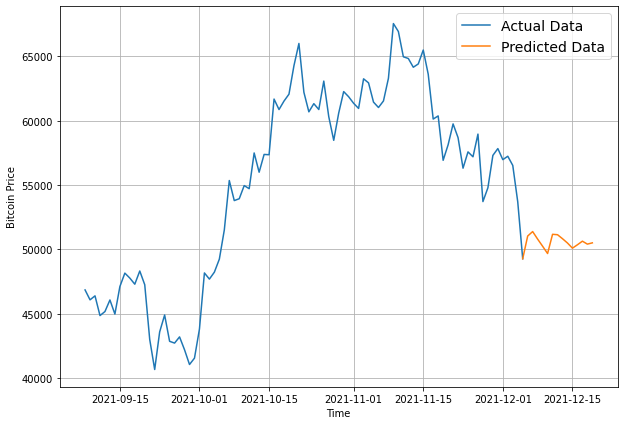

In [116]:
# Plot the graph for future predictions
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, prices, start=2500, format="-", label="Actual Data")
plot_time_series(next_time_steps, future_predictions, format="-", label="Predicted Data");